# Apply the msr.changepoint algorithm to the Windermere Perch and water quality data proposed by Pete 

In [9]:
library(dplyr)
library(ggplot2)
library(gridExtra)

#source("cpt/source.R")
setwd("/data/notebooks/jupyterlab-workshop")
#source("R/helper.R")
options(repr.plot.width = 18, repr.plot.height = 10)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




Load and manipulate Perch data

In [10]:
load_perch <- read.csv("csv/Win_Nor_Perch.csv")

## format date column to dates
load_perch$DATETIME <- as.Date(paste0("31-12-", load_perch$YEAR), format = "%d-%m-%Y")

start  <- as.Date("31-12-1989", format="%d-%m-%Y")
end <- as.Date("21-02-1999", format="%d-%m-%Y")
## MANIPULATE
## filter by:
## SITE = "Windermere (North)"
## DETERMINAND = "Perca fluviatilis"
## drop columns: 
## "SITE", "DETERMINAND", "YEAR"
## order rows by column: 
## DATE
df_perch <- load_perch %>% 
    filter(SITE == "Windermere (North)", DETERMINAND == "Perca fluviatilis") %>%
    select( -c("SITE", "DETERMINAND", "YEAR") ) %>%
    arrange(DATETIME) %>%
    filter( DATETIME >=  start) %>%
    filter( DATETIME <= end )

## remove column: DATE
df_perch <- df_perch[,c("DATETIME", "ANNUAL_AVG_ABUNDANCE")]
print( head(df_perch) )

    DATETIME ANNUAL_AVG_ABUNDANCE
1 1989-12-31                37.73
2 1990-12-31                29.10
3 1993-12-31                33.27
4 1994-12-31                16.33
5 1995-12-31                19.30
6 1996-12-31                79.67


Load and manipulate Soluable Reactive Phosphate

In [11]:
## function for bad year storage
replace <- function(x)
{
    x_int <- as.integer(x[3])
    if (x_int < 21)
    {
        x[3] <- paste0("20", x[3])
    }else
    {
        x[3] <- paste0("19", x[3])
    }
    
    return(x)
}

## ignoring: sensored values
## ignoring: change in sensor value

load_phos <- read.csv("csv/Win_Nor_PO4P.csv")
tmp = strsplit(as.character(load_phos$DATE), "-")
load_phos$DATE <- do.call(c, lapply(lapply(tmp, replace), paste0, collapse='-') )

## format DATE column to dates
load_phos$DATETIME <- as.Date(load_phos$DATE, format="%d-%b-%Y")

## MANIPULATE
## filter by:
##   VARIABLE == "PO4P"
## drop columns: 
##   "VARIABLE", "sign_if_LT_LOD"
## order rows by column: 
##   DATE
df_phos <- load_phos %>%
    filter(VARIABLE == "PO4P") %>%
    select( -c("VARIABLE", "sign_if_LT_LOD", "DATE") ) %>%
    arrange(DATETIME) %>%
    filter( DATETIME >= start ) %>%
    filter( DATETIME <= end )

print( head(df_phos) )

  VALUE   DATETIME
1  7.05 1990-01-02
2  7.24 1990-01-16
3  7.58 1990-01-30
4  7.31 1990-02-13
5  6.06 1990-02-27
6  6.90 1990-03-01


Plot the data

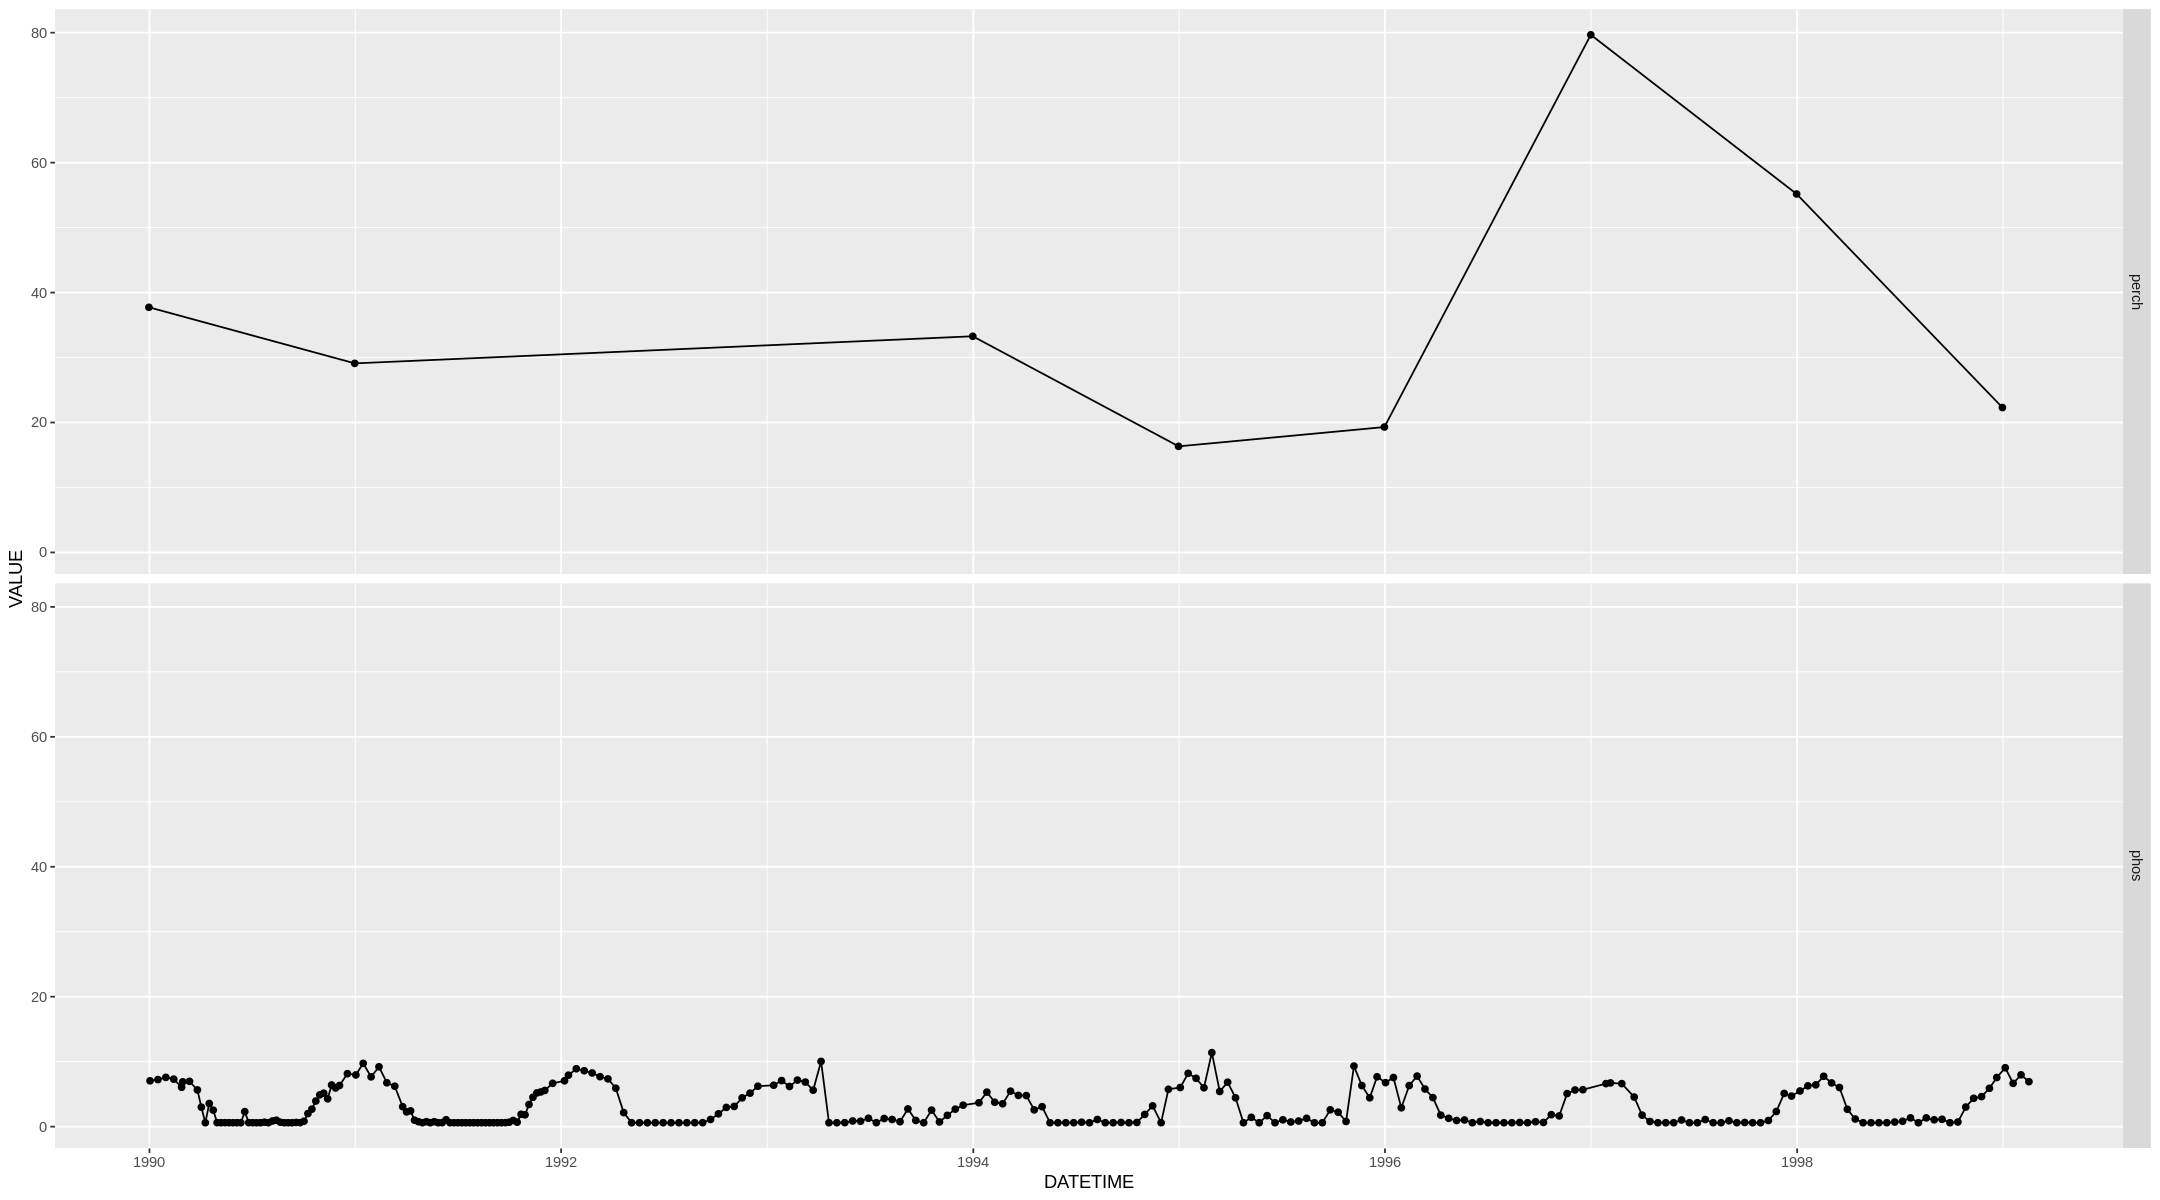

In [12]:
allData <- df_phos %>%
    mutate(type = "phos") %>%
dplyr::full_join(
    df_perch %>% 
        rename(VALUE = "ANNUAL_AVG_ABUNDANCE") %>%
        mutate(type = "perch"),
    by = c("DATETIME", "VALUE", "type")
    )

allData %>%
    ggplot(aes(x = DATETIME, y=VALUE)) +
    geom_point() + 
    geom_line() +
    facet_grid(rows = vars(type))

# Apply the changepoint.msr approach

In [13]:

library("changepoint.msr")


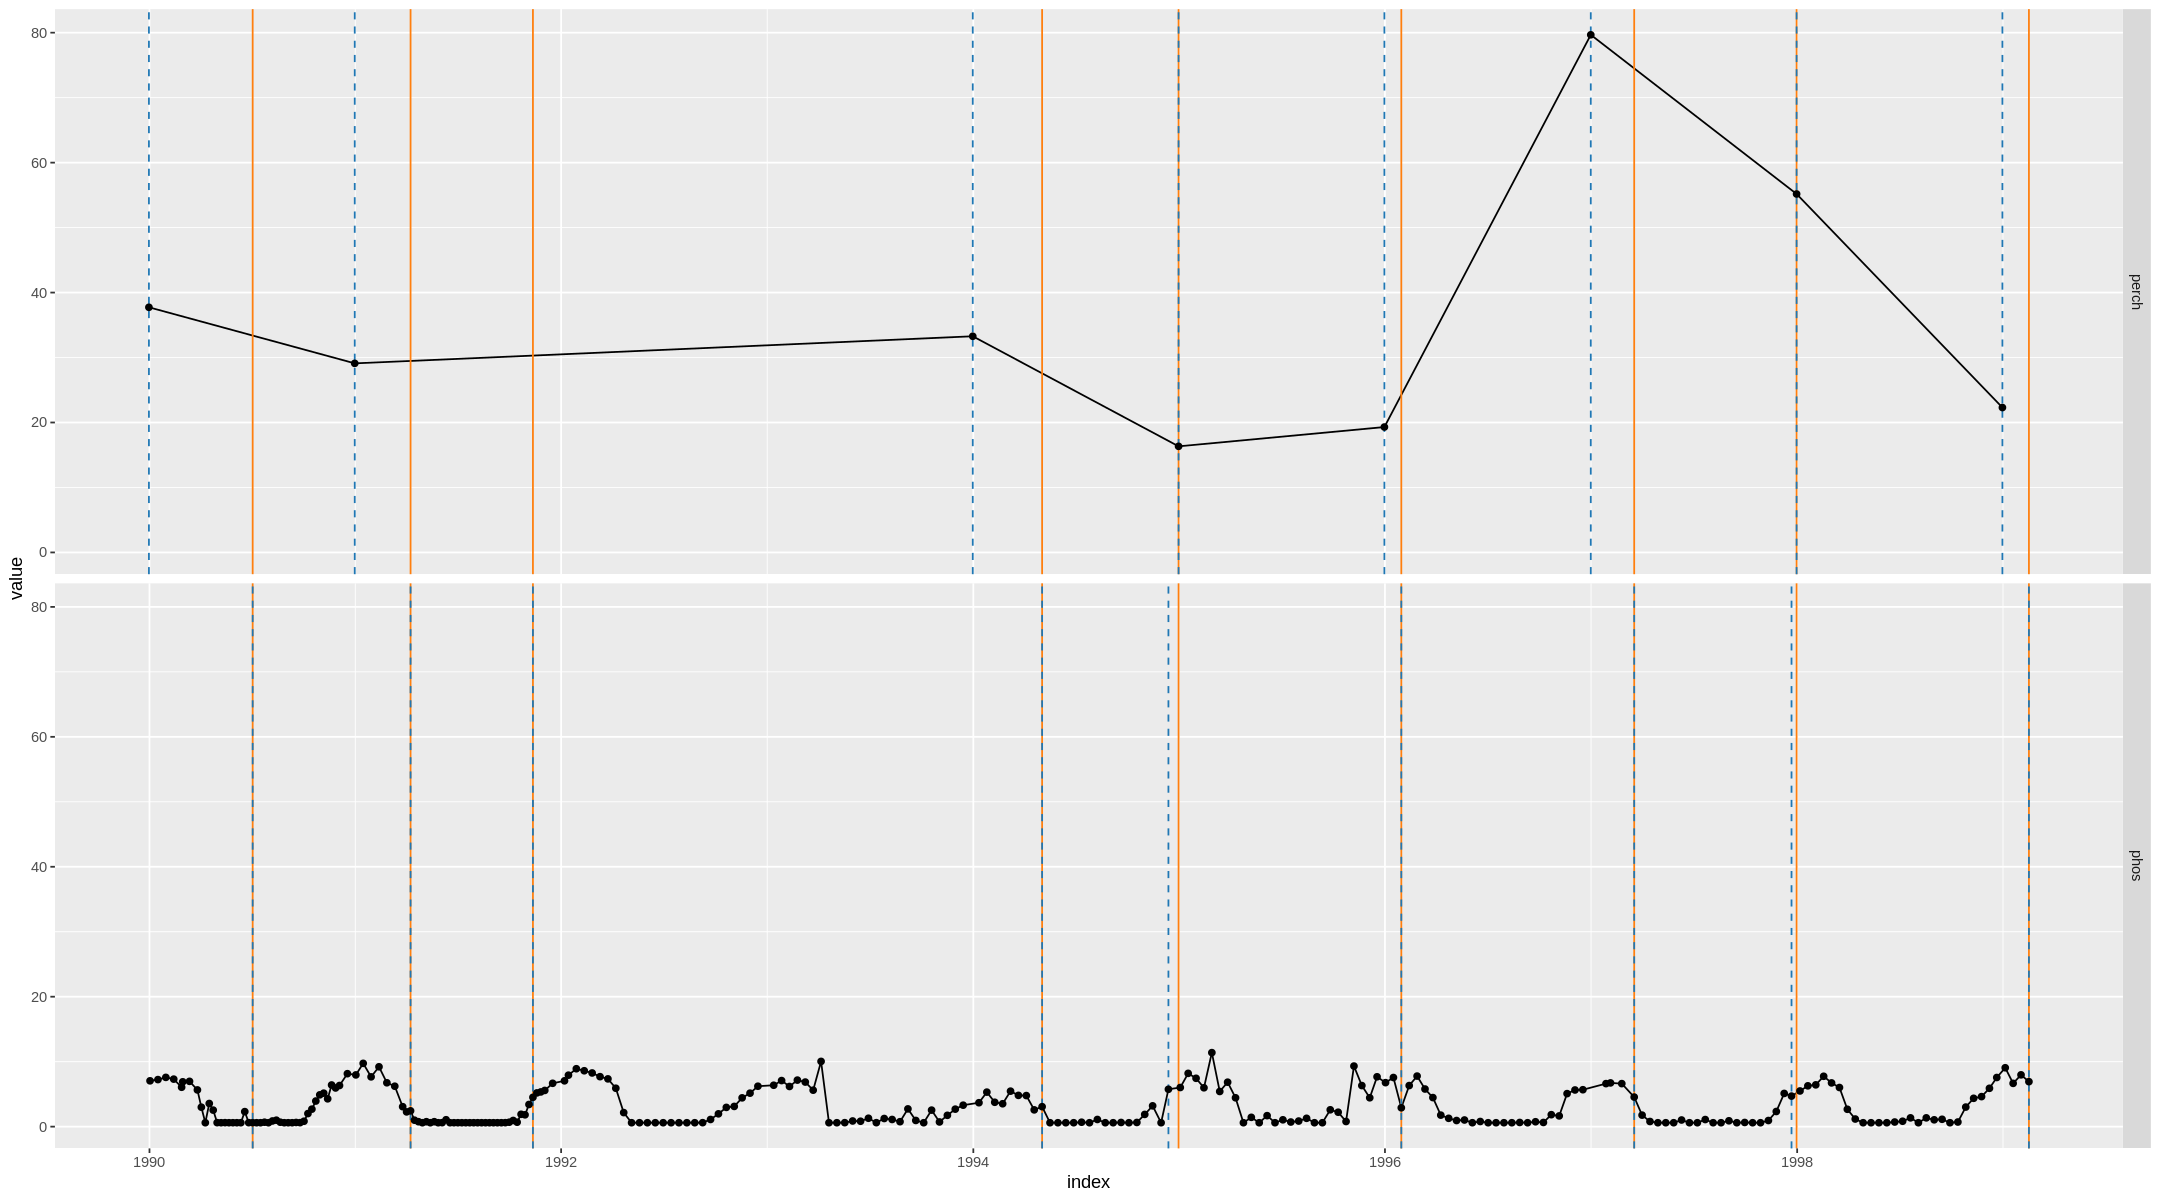

In [14]:
keys <- c("perch", "phos")
cpt.out <- cpt.msr( 
    data = allData,
    penalty = rep("bic", length(keys)),
    test.stat = rep("normal_var", length(keys)),
    key_column = "type",
    key_value = "VALUE",
    key_index = "DATETIME",
    keys = keys
)
plot(cpt.out) +
    geom_point()